In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    f1_score,
    auc,
)


sns.set(style="whitegrid")
sns.set_color_codes("pastel")

In [3]:
full_train = pd.read_csv("datasets/train_clean.csv")

to_drop = [
    "Name",
    "Ticket",
    "Embarked",
    "PassengerId",
    *[c for c in full_train if "cabin" in c.lower()],
]

full_train.drop(columns=to_drop, inplace=True)

target_col = "Survived"

X = full_train.drop(target_col, axis=1)
y = full_train[target_col]

X_train, y_train = X, y

model = GaussianNB()

param_grid = {"var_smoothing": np.logspace(0, -9, num=100)}

grid_search = GridSearchCV(
    model, param_grid, n_jobs=1, cv=5, scoring="accuracy", verbose=4
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .................var_smoothing=1.0;, score=0.691 total time=   0.0s
[CV 2/5] END .................var_smoothing=1.0;, score=0.764 total time=   0.0s
[CV 3/5] END .................var_smoothing=1.0;, score=0.764 total time=   0.0s
[CV 4/5] END .................var_smoothing=1.0;, score=0.758 total time=   0.0s
[CV 5/5] END .................var_smoothing=1.0;, score=0.780 total time=   0.0s
[CV 1/5] END ..var_smoothing=0.8111308307896871;, score=0.691 total time=   0.0s
[CV 2/5] END ..var_smoothing=0.8111308307896871;, score=0.775 total time=   0.0s
[CV 3/5] END ..var_smoothing=0.8111308307896871;, score=0.781 total time=   0.0s
[CV 4/5] END ..var_smoothing=0.8111308307896871;, score=0.753 total time=   0.0s
[CV 5/5] END ..var_smoothing=0.8111308307896871;, score=0.780 total time=   0.0s
[CV 1/5] END ...var_smoothing=0.657933224657568;, score=0.685 total time=   0.0s
[CV 2/5] END ...var_smoothing=0.65793322465756

In [4]:
import joblib

joblib.dump(
    grid_search,
    f"../models/{grid_search.best_estimator_.__class__.__name__}_{grid_search.best_score_ * 100:.4f}.joblib",
)

['models/GaussianNB_80.0927.joblib']

In [5]:
model_name = grid_search.estimator.__class__.__name__

get_best = True  # get the best model or the latest model

# get files in models sorted by last modified
if get_best:
    import os
    import re

    files = os.listdir("../models")
    files = [f for f in files if re.match(f"{model_name}_.*\.joblib", f)]
    files = sorted(
        files, key=lambda x: re.search(r"_(\d+\.\d+)\.joblib", x).group(1), reverse=True
    )
    file_name = files[0]
else:
    import os
    import re

    files = os.listdir("../models")
    files = [f for f in files if re.match(f"{model_name}_.*\.joblib", f)]
    files = sorted(
        files, key=lambda x: os.path.getmtime(os.path.join("models", x)), reverse=True
    )
    file_name = files[0]
loaded_grid_search = joblib.load(f"../models/{file_name}")

In [6]:
for k, v in loaded_grid_search.cv_results_.items():
    print(k, v, sep="\t")

mean_fit_time	[0.00168576 0.00163522 0.00143986 0.00142317 0.00137591 0.00136442
 0.00132217 0.00132599 0.00130234 0.00138755 0.00137329 0.00130844
 0.0012805  0.00134606 0.00128632 0.00154757 0.00138602 0.00153913
 0.00135603 0.00137076 0.00143404 0.00132828 0.00136576 0.00141444
 0.0013463  0.00136023 0.00127654 0.0012816  0.00126781 0.00135212
 0.00146403 0.00128074 0.00133119 0.00125756 0.00126925 0.00125966
 0.00127459 0.00125761 0.00125871 0.00129166 0.00130239 0.00127916
 0.00125918 0.00126939 0.00130277 0.00128689 0.00128374 0.00147552
 0.00130634 0.00125799 0.00128841 0.00126872 0.00130363 0.00125737
 0.00125179 0.0012445  0.0012464  0.00124049 0.00133166 0.00129552
 0.00130072 0.00125656 0.00131636 0.00135641 0.00128002 0.00124722
 0.00126791 0.00123239 0.00127263 0.00123801 0.00122547 0.0012332
 0.00123382 0.00122776 0.00122271 0.00122337 0.00127797 0.00124454
 0.00123086 0.00123706 0.0013248  0.00131416 0.00133533 0.00132065
 0.00128846 0.00127668 0.00126457 0.00125976 0.00

In [7]:
real_test = pd.read_csv("datasets/test_clean.csv")

In [8]:
real_test.drop(columns=list(set(to_drop) - {"PassengerId"}), inplace=True)

In [9]:
pred = pd.DataFrame(best_model.predict(real_test.drop(columns=["PassengerId"]))).rename(
    columns={0: "Survived"}
)

In [10]:
# get probabilities
probs = best_model.predict_proba(X_train)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# predict class values
yhat = best_model.predict(X_train)

# calculate roc-auc score
lr_auc = roc_auc_score(y_train, probs)

# calculate roc curve
ns_fpr, ns_tpr, _ = roc_curve(y_train, probs)

# get f1 score
lr_f1 = f1_score(y_train, best_model.predict(X_train))

# get auc score
lr_auc = auc(ns_fpr, ns_tpr)

# get precision & recall
lr_precision, lr_recall, _ = precision_recall_curve(y_train, probs)

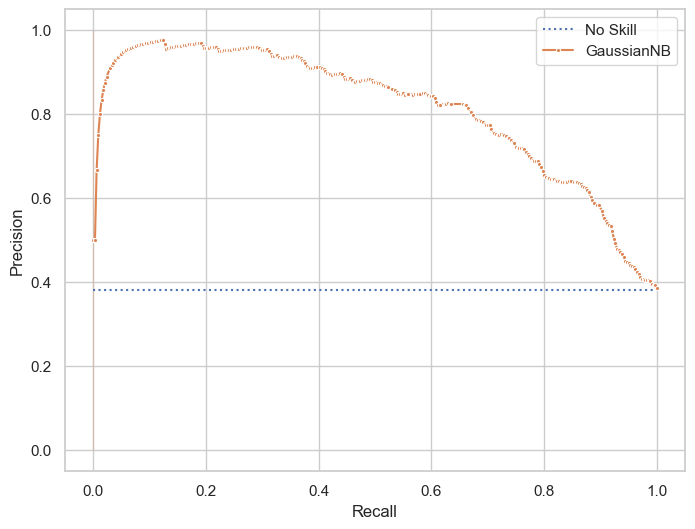

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get no-skill line
no_skill = len(y_train[y_train == 1]) / len(y_train)

# Set the style
sns.set(style="whitegrid")

# Plot the precision-recall curves
plt.figure(figsize=(8, 6))
sns.lineplot(x=[0, 1], y=[no_skill, no_skill], linestyle="dotted", label="No Skill")
sns.lineplot(x=lr_recall, y=lr_precision, marker=".", label=model_name)

# Set axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()

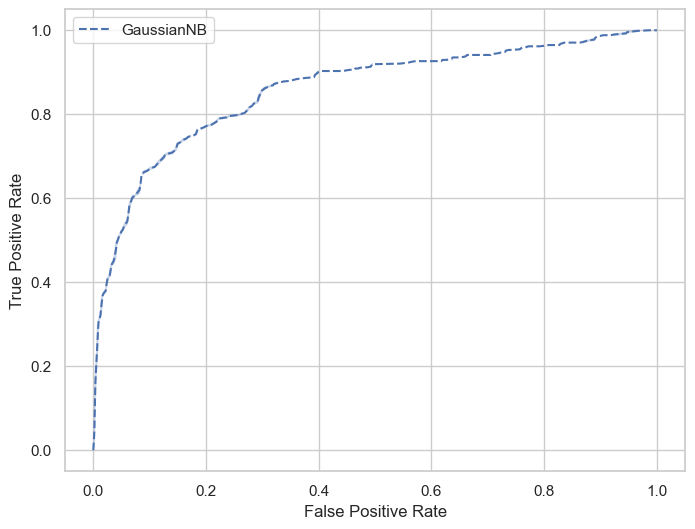

In [12]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=ns_fpr, y=ns_tpr, linestyle="--", label=model_name)

# Set axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [13]:
pd.concat([real_test[["PassengerId"]], pred], axis=1).to_csv(
    f"../outs/{best_model.__class__.__name__}_{grid_search.best_score_ * 100:.4f}.csv",
    index=False,
)